# Aim of the Project
To develop a chatbot that can understand complex queries from the user and intelligently respond.

### Background
Company X an average of over 5 million active customers across the globe and more than 100,000 active chat rooms. Due to the increased traffic, they are looking at improving their user experience with a chatbot moderator, which helps them engage in a meaningful conversation and keeps them updated on trending topics, while merely chatting with a chatbot. The Artificial Intelligence-powered chat experience provides easy access to information and a host of options to the customers.

### Business Requirement
Company X has invested in Python, PySpark, and Tensorflow. Using emerging technologies of Artificial Intelligence, Machine Learning, and Natural Language Processing,  – the chatbot should make the whole conversation as realistic as talking to an actual human.
The chatbot should understand that users have different intents and make it extremely simple to work around these by presenting the users with options and recommendations that best suit their needs.
### Suggested Approach
Company X used an approach using only Natural Language Processing, in which Seq2seq models (encoder and Decoder) are used as the state-of-the-art approach to implement end to
end text generation for a conversational bot.

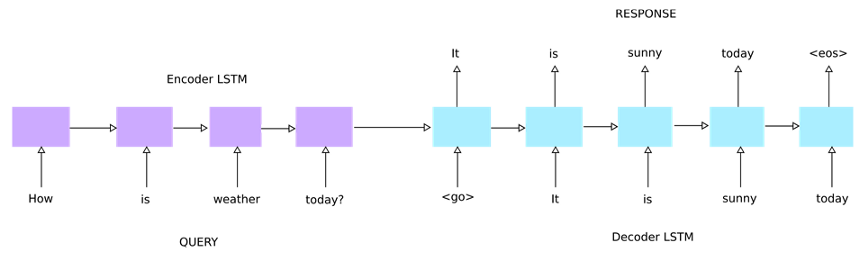

### Tasks to be performed
* Download the glove model available at https://nlp.stanford.edu/projects/glove/
* Specification: Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): glove.twitter.27B.zip
*   Load the glove word embedding into a dictionary where the key is a unique word token and the value is a d dimension vector
*   Data Preparation - Filter the conversations till max word length and convert the dialogues pairs into input text and target texts. Put start and end token to recognize the beginning and end of the sentence token
*   Create two dictionaries:
    *     target_word2id
    *     target_id2word

and save it as NumPy file format in the disk.
* Prepare the input data with embedding. The input data is a list of lists:
    *    First list is a list of sentences
    *    Each sentence is a list of words
* Generate training data per batch
* Define the model architecture and perform the following steps:
    *    Step 1: Use a LSTM encoder to get input words encoded in the form of (encoder outputs, encoder hidden state, encoder context) from input words
    *    Step 2: Use a LSTM decoder to get target words encoded in the form of (decoder outputs, decoder hidden state, decoder context) from target words. Use encoder hidden states and encoder context (represents input memory) as initial state.
    *    Step 3: Use a dense layer to predict the next token out of the vocabulary given decoder output generated by Step 2.
    *    Step 4: Use loss ='categorical_crossentropy' and optimizer='rmsprop'
* Generate the model summary
* Finally generate the prediction

### Dataset Description
Dataset: Cornell Movie Dialogue corpus
#### Brief Description
This corpus contains a large metadata-rich collection of fictional conversations extracted from raw movie scripts:
* 220,579 conversational exchanges between 10,292 pairs of movie characters
* involves 9,035 characters from 617 movies
* in total 304,713 utterances
* movie metadata included:
    * genres
    * release year
    * IMDB rating
    * number of IMDB votes
    * IMDB rating
* character metadata included:
    * - gender (for 3,774 characters)
    * - position on movie credits (3,321 characters)

#### File Description
In all files the field separator is " +++$+++ "
* movie_titles_metadata.txt
Contains information about each movie title
    * fields:
        * movieID,
        * movie title,
        * movie year,
        * IMDB rating,
        * no. IMDB votes,
        * genres in the format ['genre1','genre2',É,'genreN']
* movie_characters_metadata.txt
Contains information about each movie character
    * fields:
        * characterID
        * character name
        * movieID
        * movie title
        * gender ("?" for unlabeled cases)
        * position in credits ("?" for unlabeled cases)
* movie_lines.txt
Contains the actual text of each utterance
    * fields:
        * lineID
        * characterID (who uttered this phrase)
        * movieID
        * character name
        * text of the utterance
* movie_conversations.txt
Contains the structure of the conversations
    * fields
        * characterID of the first character involved in the conversation
        * characterID of the second character involved in the conversation
        * movieID of the movie in which the conversation occurred
        * List of the utterances that make the conversation, in chronological
            order: ['lineID1','lineID2',É,'lineIDN'] has to be matched with movie_lines.txt to reconstruct the actual content
* raw_script_urls.txt
Contains the urls from which the raw sources were retrieved

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import time
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, concatenate, TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Data loading

In [2]:
# Load the data
lines = open('../input/cornell-moviedialog-corpus/movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')
conv_lines = open('../input/cornell-moviedialog-corpus/movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n')

In [3]:
# The sentences that we will be using to train our model.
lines[:5]

['L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!',
 'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!',
 'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.',
 'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?',
 "L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go."]

In [4]:
# The sentences' ids, which will be processed to become our input and target data.
conv_lines[:5]

["u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L205', 'L206']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']"]

# Data preprocessing

In [6]:
# Create a dictionary to map each line's id with its text
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
#     print(_line)
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]

In [7]:
# Create a list of all of the conversations' lines' ids.
convs = []
for line in conv_lines[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
#     print(_line)
    convs.append(_line.split(','))
    
#id and conversation sample
# for k in convs[300]:
#     print (k, id2line[k])

### Creating question inputs and answer targets

In [8]:
# Sort the sentences into questions (inputs) and answers (targets)
questions = []
answers = []

for conv in convs:
    for i in range(len(conv)-1):
        questions.append(id2line[conv[i]])
        answers.append(id2line[conv[i+1]])
        
# Compare lengths of questions and answers
print(len(questions))
print(len(answers))

221616
221616


### Text Cleaning

In [9]:
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = " ".join(text.split())
    return text

In [10]:
# Clean the data
clean_questions = []
for question in questions:
    clean_questions.append(clean_text(question))
    
clean_answers = []    
for answer in answers:
    clean_answers.append(clean_text(answer))

In [13]:
print("======Original questions and answers=======")
print(questions[4])
print(answers[4])

print("\n======Cleaned questions and answers===")
print(clean_questions[4])
print(clean_answers[4])

======Original questions and answers=======
No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.

======Cleaned questions and answers===
no no it is my fault we did not have a proper introduction
cameron


### Selecting questions and answers with appropriate length (<20 words)

In [14]:
# Find the length of sentences
lengths = []
for question in clean_questions:
    lengths.append(len(question.split()))
for answer in clean_answers:
    lengths.append(len(answer.split()))
# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

print(lengths['counts'].describe())

print(np.percentile(lengths, 80))
print(np.percentile(lengths, 85))
print(np.percentile(lengths, 90))
print(np.percentile(lengths, 95))
print(np.percentile(lengths, 99))

count    443232.000000
mean         10.872094
std          12.215895
min           0.000000
25%           4.000000
50%           7.000000
75%          14.000000
max         555.000000
Name: counts, dtype: float64
16.0
19.0
24.0
32.0
58.0


Let's choose length of sequences to be of maximum 20.

In [15]:
VOCAB_SIZE = 20000 #50000#15000 #14999 #to decide the dimension of sentence’s one-hot vector
EMBEDDING_DIM = 100 #to decide the dimension of Word2Vec
MAX_LEN = 20  #to unify the length of the input sentences
NUM_SAMPLES = 60000 #60000  # Number of samples to train on.
GLOVE_DIR = '/kaggle/input/glove-global-vectors-for-word-representation'
EPOCHS=40 #10
BATCH_SIZE=256

In [16]:
# Remove questions and answers that are shorter than 1 word and longer than 20 words.
min_line_length = 2
max_line_length = 20

# Filter out the questions that are too short/long
short_questions_temp = []
short_answers_temp = []

for i, question in enumerate(clean_questions):
    if len(question.split()) >= min_line_length and len(question.split()) <= max_line_length:
        short_questions_temp.append(question)
        short_answers_temp.append(clean_answers[i])

# Filter out the answers that are too short/long
short_questions = []
short_answers = []

for i, answer in enumerate(short_answers_temp):
    if len(answer.split()) >= min_line_length and len(answer.split()) <= max_line_length:
        short_answers.append(answer)
        short_questions.append(short_questions_temp[i])
        
print(len(short_questions))
print(len(short_answers))


r = np.random.randint(1,len(short_questions))
for i in range(r, r+3):
    print(short_questions[i])
    print(short_answers[i])
    print()

138335
138335
we are cosponsoring the acid rain mixer at the sig ep house tonight
why are not you there

why are not you there
i am designated driver i have to be here in case a sister calls and needs a ride

i am designated driver i have to be here in case a sister calls and needs a ride
that is too bad



In [17]:
#choosing number of samples
# encoder_input_text = clean_questions[:NUM_SAMPLES]
encoder_input_text = short_questions[:NUM_SAMPLES]

### Put BOS tag and EOS tag for decoder input

In [18]:
def tagger(input_text):
  bos = "<BOS> "
  eos = " <EOS>"
  final_target = [bos + text + eos for text in input_text] 
  return final_target

# clean_answers = clean_answers[:NUM_SAMPLES]
# decoder_input_text = tagger(clean_answers)
# decoder_input_text[:5]
short_answers = short_answers[:NUM_SAMPLES]
decoder_input_text = tagger(short_answers)
decoder_input_text[:5]

['<BOS> not the hacking and gagging and spitting part please <EOS>',
 '<BOS> okay then how about we try out some french cuisine saturday night <EOS>',
 '<BOS> forget it <EOS>',
 '<BOS> let me see what i can do <EOS>',
 '<BOS> right see you are ready for the quiz <EOS>']

In [19]:
print(len(encoder_input_text))
print(len(decoder_input_text))

60000
60000


### Make Vocabulary (VOCAB_SIZE)

In [20]:
tokenizer = Tokenizer(num_words= VOCAB_SIZE, filters='')

def vocab_creater(text_lists, VOCAB_SIZE):  
  tokenizer.fit_on_texts(text_lists)
  dictionary = tokenizer.word_index
  
  word2idx = {}
  idx2word = {}
  for k, v in dictionary.items():
      if v < VOCAB_SIZE:
          word2idx[k] = v
          idx2word[v] = k
      if v >= VOCAB_SIZE-1:
          continue
          
  return word2idx, idx2word

word2idx, idx2word = vocab_creater(text_lists=encoder_input_text+decoder_input_text, VOCAB_SIZE=VOCAB_SIZE)

#print first few key/value pairs
word2idx_first5pairs = {k: word2idx[k] for k in list(word2idx)[:5]}
print('word2idx: ', word2idx_first5pairs)

idx2word_first5pairs = {k: idx2word[k] for k in list(idx2word)[:5]}
print('\nidx2word: ', idx2word_first5pairs)

# Check the length of the dictionaries.
print('word2idx length', len(word2idx))
print('idx2word length', len(idx2word))

word2idx:  {'<bos>': 1, '<eos>': 2, 'you': 3, 'i': 4, 'the': 5}

idx2word:  {1: '<bos>', 2: '<eos>', 3: 'you', 4: 'i', 5: 'the'}
word2idx length 19999
idx2word length 19999


### Tokenize Bag of words to Bag of IDs

In [21]:
def text2seq(tokenizer, encoder_text, decoder_text, VOCAB_SIZE):

#   tokenizer = Tokenizer(num_words=VOCAB_SIZE)
  encoder_sequences = tokenizer.texts_to_sequences(encoder_text)
  decoder_sequences = tokenizer.texts_to_sequences(decoder_text)
  
  return encoder_sequences, decoder_sequences

encoder_sequences, decoder_sequences = text2seq(tokenizer, encoder_input_text, decoder_input_text, VOCAB_SIZE)
print('encoder_sequences:\n', encoder_sequences[:5])
print('\ndecoder_sequences:\n', decoder_sequences[:5])

encoder_sequences:
 [[51, 4, 136, 19, 35, 293, 36, 17814, 54, 12, 6, 101, 36, 3], [7, 5, 9560, 18, 7938, 18, 6088, 393, 139], [3, 13, 465, 16, 48, 12, 6, 45, 941, 12, 6, 28, 159, 164], [1551, 54, 124, 19, 77, 147, 3094, 10, 1488], [17815, 991, 17816, 25, 6, 29, 354]]

decoder_sequences:
 [[1, 7, 5, 9560, 18, 7938, 18, 6088, 393, 139, 2], [1, 101, 86, 42, 37, 19, 221, 48, 83, 1101, 1996, 150, 2], [1, 288, 9, 2], [1, 122, 16, 69, 14, 4, 52, 11, 2], [1, 55, 69, 3, 13, 356, 26, 5, 10775, 2]]


### Padding (MAX_LEN)

In [22]:
def padding(encoder_sequences, decoder_sequences, MAX_LEN):
  
  encoder_input_data = pad_sequences(encoder_sequences, maxlen=MAX_LEN, dtype='int32', padding='post', truncating='post')
  decoder_input_data = pad_sequences(decoder_sequences, maxlen=MAX_LEN, dtype='int32', padding='post', truncating='post')
  
  return encoder_input_data, decoder_input_data

encoder_input_data, decoder_input_data = padding(encoder_sequences, decoder_sequences, MAX_LEN)
print('encoder_input_data:\n', encoder_input_data)
print('\ndecoder_input_data:\n', decoder_input_data)

encoder_input_data:
 [[  51    4  136 ...    0    0    0]
 [   7    5 9560 ...    0    0    0]
 [   3   13  465 ...    0    0    0]
 ...
 [ 603 3243 2132 ...    0    0    0]
 [ 609   22    6 ...    0    0    0]
 [  40   22   33 ...    0    0    0]]

decoder_input_data:
 [[  1   7   5 ...   0   0   0]
 [  1 101  86 ...   0   0   0]
 [  1 288   9 ...   0   0   0]
 ...
 [  1  68 113 ...   0   0   0]
 [  1  40  22 ...   0   0   0]
 [  1  40  22 ...   0   0   0]]


### Reshape the Data to neural network shape

In [23]:
num_samples = len(encoder_sequences)

def decoder_output_creator(decoder_input_data, num_samples, MAX_LEN, VOCAB_SIZE):
  decoder_output_data = np.zeros((num_samples, MAX_LEN, VOCAB_SIZE), dtype="float32")
  for i, seqs in enumerate(decoder_input_data):
      for t, seq in enumerate(seqs):
          if t > 0:                
                decoder_output_data[i][t][seq] = 1.  #decoder_output_data[i, t, seq] = 1.
  
  return decoder_output_data

decoder_output_data = decoder_output_creator(decoder_input_data, num_samples, MAX_LEN, VOCAB_SIZE)

In [24]:
print (encoder_input_data.shape)
print (decoder_input_data.shape)
print (decoder_output_data.shape)

(60000, 20)
(60000, 20)
(60000, 20, 20000)


### Word Embedding (EMBEDDING_DIM)

We use Pretraind Word2Vec Model from Glove. We can create embedding layer with Glove with 3 steps:
1. Call Glove file
1. Create Embedding Matrix from our Vocabulary
1. Create Embedding Layer

In [25]:
# Call Glove file
def glove_100d_dictionary(glove_dir):
  embeddings_index = {}
  f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()
  return embeddings_index

embeddings_index = glove_100d_dictionary(GLOVE_DIR)
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [26]:
#Create Embedding Matrix from our Vocabulary
def embedding_matrix_creater(max_words, embedding_dimension):
  embedding_matrix = np.zeros((max_words, embedding_dimension))  #np.zeros((len(word2idx) + 1, embedding_dimension))
  for word, i in word2idx.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
  return embedding_matrix

embedding_matrix = embedding_matrix_creater(VOCAB_SIZE, EMBEDDING_DIM)
print(embedding_matrix.shape)
print((len(word2idx) + 1))

(20000, 100)
20000


In [27]:
#Create Embedding Layer
def embedding_layer_creater(VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, embedding_matrix):
  
  embedding_layer = Embedding(input_dim = VOCAB_SIZE, 
                              output_dim = EMBEDDING_DIM,
                              input_length = MAX_LEN,
                              weights = [embedding_matrix],
                              trainable = False)
  return embedding_layer

embedding_layer = embedding_layer_creater(VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, embedding_matrix)

embedding_layer2 = embedding_layer_creater(VOCAB_SIZE, EMBEDDING_DIM, None, embedding_matrix)

###  Split data for training validation & testing

In [28]:
def data_spliter(encoder_input_data, decoder_input_data, test_size1=0.2, test_size2=0.3):  
  en_train, en_test, de_train, de_test = train_test_split(encoder_input_data, decoder_input_data, test_size=test_size1)
  en_train, en_val, de_train, de_val = train_test_split(en_train, de_train, test_size=test_size2)
  
  return en_train, en_val, en_test, de_train, de_val, de_test

en_train, en_val, en_test, de_train, de_val, de_test = data_spliter(encoder_input_data, decoder_input_data)

# Create Seq2Seq Neural Network Architecture

Seq2Seq is a type of Encoder-Decoder model using RNN. It can be used as a model for machine interaction and machine translation. By learning a large number of sequence pairs, this model generates one from the other. More kindly explained, the definition of Seq2Seq is below:
* Input: Text Data
* Output: Text Data as well

Below is our Seq2Seq Neural Network Architecture using LSTM.

In [29]:
def build_seq2seq_model(HIDDEN_DIM=300):
    #set up the encoder
    encoder_inputs = Input(shape=(MAX_LEN, ), dtype='int32',)
    encoder_embedding = embedding_layer(encoder_inputs)
    encoder_LSTM = LSTM(HIDDEN_DIM, return_state=True)
    encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
    encoder_states = [state_h, state_c]
    
    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(MAX_LEN, ), dtype='int32',)
    decoder_embedding = embedding_layer(decoder_inputs)
    decoder_LSTM = LSTM(HIDDEN_DIM, return_state=True, return_sequences=True)
    decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=encoder_states)
    
    decoder_dense = Dense(VOCAB_SIZE, activation='softmax')
    outputs = TimeDistributed(decoder_dense)(decoder_outputs)
    
    #create seq2seq model
    model = Model([encoder_inputs, decoder_inputs], outputs)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc']) #sparse_categorical_crossentropy as labels in a single integer array
    
    #create encoder model
    encoder_model = Model(encoder_inputs, encoder_states)
    
    #Create sampling/decoder model
    decoder_state_input_h  = Input(shape=(HIDDEN_DIM,))
    decoder_state_input_c = Input(shape=(HIDDEN_DIM,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_embedding2= embedding_layer(decoder_inputs)
    decoder_outputs2, state_h2, state_c2 = decoder_LSTM(decoder_embedding2, initial_state=decoder_states_inputs)
    decoder_states2 = [state_h2, state_c2]
    decoder_outputs2 = decoder_dense(decoder_outputs2)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states2)
    
    return model, encoder_model, decoder_model

def build_seq2seq_model2(HIDDEN_DIM=300):
    #set up the encoder
    encoder_inputs = Input(shape=(None, ), dtype='int32',)
    encoder_embedding = embedding_layer2(encoder_inputs)
    encoder_LSTM = LSTM(HIDDEN_DIM, return_state=True)
    encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
    encoder_states = [state_h, state_c]
    
    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None, ), dtype='int32',)
    decoder_embedding = embedding_layer2(decoder_inputs)
    decoder_LSTM = LSTM(HIDDEN_DIM, return_state=True, return_sequences=True)
    decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=encoder_states)
    
    decoder_dense = Dense(VOCAB_SIZE, activation='softmax')
    outputs = TimeDistributed(decoder_dense)(decoder_outputs)
    
    #create seq2seq model
    model = Model([encoder_inputs, decoder_inputs], outputs)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc']) #sparse_categorical_crossentropy as labels in a single integer array
    
    #create encoder model
    encoder_model = Model(encoder_inputs, encoder_states)
    
    #Create sampling/decoder model
    decoder_state_input_h  = Input(shape=(HIDDEN_DIM,))
    decoder_state_input_c = Input(shape=(HIDDEN_DIM,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_embedding2= embedding_layer2(decoder_inputs)
    decoder_outputs2, state_h2, state_c2 = decoder_LSTM(decoder_embedding2, initial_state=decoder_states_inputs)
    decoder_states2 = [state_h2, state_c2]
    decoder_outputs2 = decoder_dense(decoder_outputs2)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states2)
    
    return model, encoder_model, decoder_model

model, encoder_model, decoder_model = build_seq2seq_model2(HIDDEN_DIM=300)
model.summary()

# model, encoder_model, decoder_model = build_seq2seq_model(HIDDEN_DIM=300)
# model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    2000000     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 300), (None, 481200      embedding_2[0][0]          

In [30]:
encoder_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
lstm_1 (LSTM)                [(None, 300), (None, 300) 481200    
Total params: 2,481,200
Trainable params: 481,200
Non-trainable params: 2,000,000
_________________________________________________________________


In [31]:
decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    2000000     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 300)          0                                            
____________________________________________________________________________________________

# Train the model

In [32]:
#early stopping & saving
# es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
mcp = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model.fit([encoder_input_data, decoder_input_data], decoder_output_data,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.05,
          callbacks= [mcp]
         )

Train on 57000 samples, validate on 3000 samples
Epoch 1/40
57000/57000 [==============================] - 207s 4ms/step - loss: 2.1205 - acc: 0.6592 - val_loss: 1.0333 - val_acc: 0.8313
Epoch 2/40
57000/57000 [==============================] - 171s 3ms/step - loss: 0.6595 - acc: 0.8737 - val_loss: 0.4701 - val_acc: 0.8995
Epoch 3/40
57000/57000 [==============================] - 171s 3ms/step - loss: 0.3639 - acc: 0.9095 - val_loss: 0.3500 - val_acc: 0.9140
Epoch 4/40
57000/57000 [==============================] - 171s 3ms/step - loss: 0.2682 - acc: 0.9203 - val_loss: 0.2992 - val_acc: 0.9196
Epoch 5/40
57000/57000 [==============================] - 171s 3ms/step - loss: 0.2170 - acc: 0.9259 - val_loss: 0.2717 - val_acc: 0.9224
Epoch 6/40
57000/57000 [==============================] - 171s 3ms/step - loss: 0.1837 - acc: 0.9294 - val_loss: 0.2459 - val_acc: 0.9246
Epoch 7/40
57000/57000 [==============================] - 171s 3ms/step - loss: 0.1595 - acc: 0.9317 - val_loss: 0.2325 - v

# Predictions

In [33]:
def translate_sentence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = word2idx['<bos>']
    eos = word2idx['<eos>']
    output_sentence = []

    for _ in range(MAX_LEN):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)        
        # Sample a token
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]  # Update states

    return ' '.join(output_sentence)

for index in range(10):
    i = np.random.randint(1, len(encoder_input_data))
    input_seq = encoder_input_data[i:i+1]
    translation = translate_sentence(input_seq)
    print('-')
    print('Input:', short_answers[i])
    print('Response:', translation)

-
Input: we are brothers
Response: there's who's there's
-
Input: you have come to the right man
Response: there's who's
-
Input: what do you mean you can see
Response: there's there's
-
Input: y'all never use it
Response: there's there's
-
Input: right wait what do you mean
Response: there's let's let's
-
Input: all right peter good night
Response: there's there's
-
Input: makes two of us
Response: there's uhhuh
-
Input: to do what to do what for chrissake to help her to do what she is dead
Response: there's there's
-
Input: it acts as a drug on the body
Response: there's let's
-
Input: can you move the ice afterwards i do not know nobody who can move ice
Response: there's let's
